# Import Modules

In [1]:
import dataset as ds
import config as cfg
from sklearn.model_selection import train_test_split
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

from clearml import Task
import clearml
clearml.browser_login()


# ClearML
https://app.clear.ml/dashboard

# Import Dataset

In [2]:
# Base paths for the images and labels
train_images_path = f'{cfg.BASE_DATASET}/images/train'
train_labels_path = f'{cfg.BASE_DATASET}/labels/train'
val_images_path = f'{cfg.BASE_DATASET}/images/valid'
val_labels_path = f'{cfg.BASE_DATASET}/labels/valid'

# Base path for metadata
metadata_path = f'{cfg.BASE_DATASET}/metadata.json'

# Create the DataFrames for the train and validation sets
train_df = ds.create_dataframe(train_images_path, train_labels_path, metadata_path)
valid_df = ds.create_dataframe(val_images_path, val_labels_path, metadata_path)

# Test Parameters

In [38]:
project_name= cfg.PROJECT_NAME + '/tf_clf'
dataset_name = 'test500'
dataset_dir = cfg.CLF_DATASET_DIR + f'/{dataset_name}'
project_dir = f'{cfg.CLF_PROJECT_DIR}/{dataset_name}/'
class_names = cfg.CLF_CLASS_NAMES

epochs = 20
zoom_factor = 1

_, test_train_df = train_test_split(
    train_df,
    test_size=500,  # Number of items you want in your sample
    stratify=train_df['ac'],  # Stratify based on the combined column
    #random_state=42  # Ensures reproducibility
)

_, test_val_df = train_test_split(
    valid_df,
    test_size=100,  # Number of items you want in your sample
    stratify=valid_df['ac'],  # Stratify based on the combined column
    #random_state=42  # Ensures reproducibility
)

ds.create_sub_dataset(dataset_dir, test_train_df, test_val_df, class_names)


Removing dataset if pre-existing
Copying training files:


Copying files:   0%|          | 0/1000 [00:00<?, ?it/s]

Copying validation files:


Copying files:   0%|          | 0/200 [00:00<?, ?it/s]

Dataset 'test500' created at C:\github\Third-Year-Project\Intruder-Aircraft-Detection\datasets\Custom\test500


In [39]:
# Pre-processing to AID classification

ds.pre_process_dataset_for_classification(dataset_dir, zoom_factor)


Processing images:   0%|          | 0/500 [00:00<?, ?it/s]

An error occurred with C:/github/Third-Year-Project/Intruder-Aircraft-Detection/datasets/Custom/test500\images\train\26657.jpg: Expected x_max for bbox (0.27437150000000005, 0.117452, 1.1447385, 0.697696, 0) to be in the range [0.0, 1.0], got 1.1447385.
An error occurred with C:/github/Third-Year-Project/Intruder-Aircraft-Detection/datasets/Custom/test500\images\train\67206.jpg: Expected y_max for bbox (0.130334, 0.7835955, 0.468678, 1.0091585, 0) to be in the range [0.0, 1.0], got 1.0091585.


Processing images:   0%|          | 0/100 [00:00<?, ?it/s]

An error occurred with C:/github/Third-Year-Project/Intruder-Aircraft-Detection/datasets/Custom/test500\images\valid\34944.jpg: Expected y_max for bbox (0.4495395, 0.6850395, 0.9521525, 1.0201145, 0) to be in the range [0.0, 1.0], got 1.0201145.


In [40]:
ds.correct_dataset_labels(dataset_dir, test_train_df, test_val_df, class_names)

Processing train labels in test500:


Processing labels:   0%|          | 0/500 [00:00<?, ?it/s]

File not found: C:/github/Third-Year-Project/Intruder-Aircraft-Detection/datasets/Custom/test500/labels/train\26657.txt
File not found: C:/github/Third-Year-Project/Intruder-Aircraft-Detection/datasets/Custom/test500/labels/train\67206.txt
Processing valid labels in test500:


Processing labels:   0%|          | 0/100 [00:00<?, ?it/s]

File not found: C:/github/Third-Year-Project/Intruder-Aircraft-Detection/datasets/Custom/test500/labels/valid\34944.txt
Label correction completed.


In [41]:
augmentation_metadata = {
    'methods': {        
        'flip': {
            'parameters': {
                'orientation': 'h',  # Could be 'h' for horizontal or 'v' for vertical
                'p': 1.0  # Probability of applying the augmentation
            },
            'apply_to_percentage': 0.5  # 50% of the training images
        }        
    }
}

ds.augment_dataset(dataset_dir, augmentation_metadata)

Removing existing directories/files:   0%|          | 0/3 [00:00<?, ?it/s]

Copying files:   0%|          | 0/498 [00:00<?, ?it/s]

Copying files:   0%|          | 0/498 [00:00<?, ?it/s]

Applying augmentations:   0%|          | 0/249 [00:00<?, ?it/s]

In [42]:
ds.reorganize_dataset_for_keras(dataset_dir)

Moving images in train:   0%|          | 0/498 [00:00<?, ?it/s]

Moving images in train-aug:   0%|          | 0/747 [00:00<?, ?it/s]

Moving images in valid:   0%|          | 0/99 [00:00<?, ?it/s]

# Image Classifier

In [43]:
## check GPU available
#gpus = tf.config.list_physical_devices('GPU')
#print(gpus)
#
## limit vram usage
#for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)

In [44]:
# directories of train, train-aug and validation
train_dir = os.path.join(dataset_dir,'images','train')
train_aug_dir = os.path.join(dataset_dir,'images','train-aug')
valid_dir = os.path.join(dataset_dir,'images','valid')

# load datasets using keras
train_data = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                         batch_size=32, 
                                                         shuffle=True)
train_aug_data = tf.keras.utils.image_dataset_from_directory(train_aug_dir,
                                                             batch_size=32,
                                                             shuffle=True)
valid_data = tf.keras.utils.image_dataset_from_directory(valid_dir,
                                                         batch_size=32,
                                                         shuffle=True)

# scale images between 0 and 1
train_data = train_data.map(lambda x,y: (x/255, y))
train_aug_data = train_aug_data.map(lambda x,y: (x/255, y))
valid_data = valid_data.map(lambda x,y: (x/255, y))

Found 498 files belonging to 3 classes.
Found 747 files belonging to 3 classes.
Found 99 files belonging to 3 classes.


In [45]:
# TEST - use numpy to turn dataset into iterator for ease of use with batches, call each batch with .next()
train_iterator = train_data.as_numpy_iterator()
train_batch = train_iterator.next()

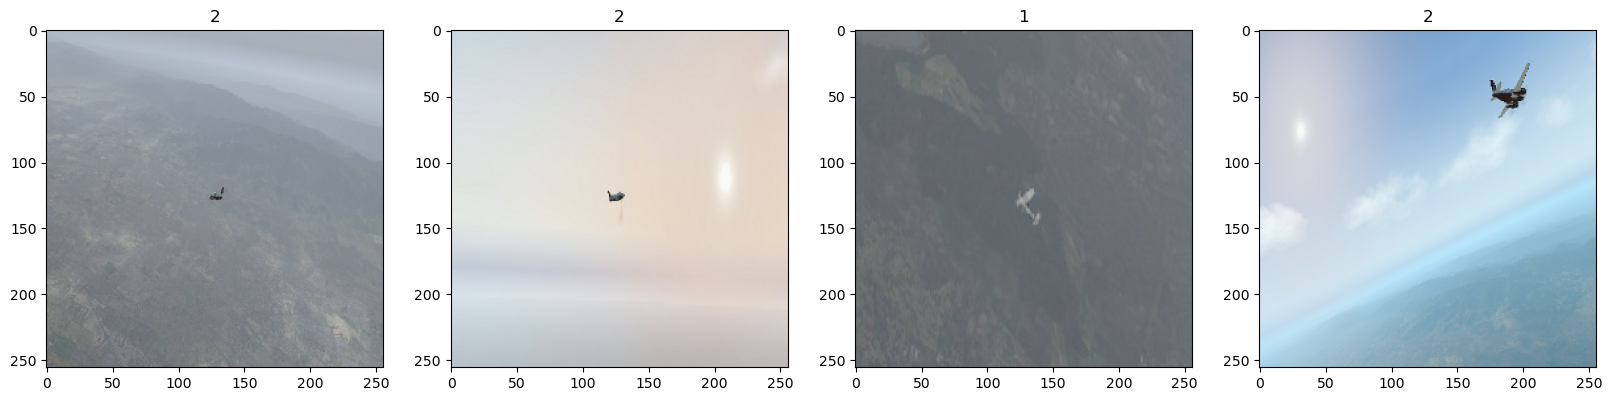

In [46]:
# TEST - visualise images with class labels
train_batch = train_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(train_batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(train_batch[1][idx])


In [47]:
# use numpy to turn dataset into iterator for ease of use with batches, call each batch with .next()
#train_data.as_numpy_iterator().next()
#train_aug_data.as_numpy_iterator().next()
#valid_data.as_numpy_iterator().next()
#
#print("done")

In [48]:

def get_model():

    tf.random.set_seed(42)
    # model architecture - Also try ResNet50 or VGG16
    model = Sequential()
    model.add(Input(shape=(256,256,3)))  # Add an Input layer to specify the input shape
    model.add(Conv2D(32, (3,3), activation='relu'))  # Notice that we no longer need to specify the input_shape here
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(16, (3,3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(3, activation='softmax'))  # Assuming you have 3 classes

    model.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])
    #model.summary()
    
    return model


In [49]:
# train pure

# local logs directory
logs_dir=cfg.CLF_PROJECT_DIR
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_dir)

#connect to clearml
task = Task.init(project_name=project_name, task_name=f"{dataset_name}-pure-eps:{epochs}-zf:{zoom_factor}")
logger = task.get_logger()

# clearml hyperparameters
hyper_params = {'epochs': epochs}
task.connect(hyper_params)

model = get_model()

# trian model
train_hst = model.fit(
    train_data, 
    epochs=hyper_params['epochs'], 
    validation_data=valid_data, 
    callbacks=[tensorboard_callback])

# send metrics to clearML
for epoch in range(epochs):
    # Log training metrics
    logger.report_scalar('loss', 'train', iteration=epoch, value=train_hst.history['loss'][epoch])
    logger.report_scalar('accuracy', 'train', iteration=epoch, value=train_hst.history['accuracy'][epoch])

    # Log validation metrics
    logger.report_scalar('loss', 'validation', iteration=epoch, value=train_hst.history['val_loss'][epoch])
    logger.report_scalar('accuracy', 'validation', iteration=epoch, value=train_hst.history['val_accuracy'][epoch])

# close task
task.close()
model = None
train_hst = None


ClearML Task: created new task id=244b095e40bd4d6e95a88f0416fde105
ClearML results page: https://app.clear.ml/projects/7e589bc2db6e4e3ba6e0ae59cc527576/experiments/244b095e40bd4d6e95a88f0416fde105/output/log
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 324ms/step - accuracy: 0.3121 - loss: 1.5461 - val_accuracy: 0.3232 - val_loss: 1.0983
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 282ms/step - accuracy: 0.3413 - loss: 1.0991 - val_accuracy: 0.3232 - val_loss: 1.0986
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 266ms/step - accuracy: 0.3159 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0984
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 269ms/step - accuracy: 0.4023 - loss: 1.0978 - val_accuracy: 0.3636 - val_loss: 1.0993
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 274ms/step - accuracy: 0.4136 - loss: 1.1015 - val_accuracy: 0.3232 - val_loss: 1.1714
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 286ms/step - accuracy: 0.4545 - loss: 1.1078 - val_accuracy: 0.3737 - val_loss: 1.1292
Epoch 7/20
16/16 ━━━━━━━

In [50]:
# train aug

# local logs directory
logs_dir=cfg.CLF_PROJECT_DIR
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_dir)

#connect to clearml
task = Task.init(project_name=project_name, task_name=f"{dataset_name}-aug-eps:{epochs}-zf:{zoom_factor}")
logger = task.get_logger()


# clearml hyperparameters
hyper_params = {'epochs': epochs}
task.connect(hyper_params)

# reset model from previous test
model = get_model()

# trian model
train_hst = model.fit(
    train_aug_data, 
    epochs=hyper_params['epochs'], 
    validation_data=valid_data, 
    callbacks=[tensorboard_callback])

# send metrics to clearML
for epoch in range(epochs):
    # Log training metrics
    logger.report_scalar('loss', 'train', iteration=epoch, value=train_hst.history['loss'][epoch])
    logger.report_scalar('accuracy', 'train', iteration=epoch, value=train_hst.history['accuracy'][epoch])

    # Log validation metrics
    logger.report_scalar('loss', 'validation', iteration=epoch, value=train_hst.history['val_loss'][epoch])
    logger.report_scalar('accuracy', 'validation', iteration=epoch, value=train_hst.history['val_accuracy'][epoch])
    
# close task
task.close()
model = None
train_hst = None


ClearML Task: created new task id=6fba56d519d447e8879c5dc0f86d8d4b
ClearML results page: https://app.clear.ml/projects/7e589bc2db6e4e3ba6e0ae59cc527576/experiments/6fba56d519d447e8879c5dc0f86d8d4b/output/log
Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 292ms/step - accuracy: 0.3727 - loss: 1.3497 - val_accuracy: 0.3434 - val_loss: 1.0986
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 277ms/step - accuracy: 0.3553 - loss: 1.0996 - val_accuracy: 0.3232 - val_loss: 1.0991
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 283ms/step - accuracy: 0.3158 - loss: 1.1006 - val_accuracy: 0.3434 - val_loss: 1.0985
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 270ms/step - accuracy: 0.3456 - loss: 1.0991 - val_accuracy: 0.3333 - val_loss: 1.0974
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 281ms/step - accuracy: 0.4262 - loss: 1.0820 - val_accuracy: 0.3838 - val_loss: 1.0827
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 274ms/step - accuracy: 0.5972 - loss: 0.9812 - val_accuracy: 0.5455 - val_loss: 1.0870
Epoch 7/20
24/24 ━━━━━━━

# Evaluation